# A r-fMRI preprocessing workflow

This is the rfMRI pre-processing workflow of our team: Aki, Clemens, Grace, Robin, Steve.

In [1]:
# Import Image helper to render graphs in the notebook
from IPython.display import Image
# Import workflow elements
from nipype import Node, Workflow
from nipype.interfaces import fsl, afni

In [2]:
# Import necessary interfaces and wrap them with nodes
node_bet = Node(fsl.BET(functional=True, mask=True), name='bet')
node_mcflirt = Node(fsl.MCFLIRT(save_plots=True, save_mats=True), name='mcflirt')
node_despike = Node(afni.Despike(outputtype='NIFTI_GZ'), name='despike')

In [3]:
# Initiation of a workflow
wf = Workflow(name="rfmri_preprocessing")

In [4]:
# First the "simple", but more restricted method
wf.connect(node_bet, "out_file", node_mcflirt, "in_file")
wf.connect(node_mcflirt, 'out_file', node_despike, 'in_file')

In [5]:
wf.inputs.bet.in_file='/home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-fingerfootlips_bold.nii.gz'
wf.base_dir='/home/jovyan/work/outputs'

170329-19:50:50,522 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/outputs/rfmri_preprocessing/graph.dot.png (graph2use=hierarchical, simple_form=True).


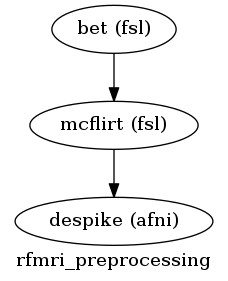

In [6]:
Image(wf.write_graph())

In [7]:
wf.run()

170329-19:50:50,572 workflow INFO:
	 Workflow rfmri_preprocessing settings: ['check', 'execution', 'logging']
170329-19:50:50,590 workflow INFO:
	 Running serially.
170329-19:50:50,595 workflow INFO:
	 Executing node bet in dir: /home/jovyan/work/outputs/rfmri_preprocessing/bet
170329-19:50:50,633 workflow INFO:
	 Running: bet /home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-fingerfootlips_bold.nii.gz /home/jovyan/work/outputs/rfmri_preprocessing/bet/sub-01_task-fingerfootlips_bold_brain.nii.gz -F -m
170329-19:50:56,284 workflow INFO:
	 Executing node mcflirt in dir: /home/jovyan/work/outputs/rfmri_preprocessing/mcflirt
170329-19:50:56,320 workflow INFO:
	 Running: mcflirt -in /home/jovyan/work/outputs/rfmri_preprocessing/bet/sub-01_task-fingerfootlips_bold_brain.nii.gz -out /home/jovyan/work/outputs/rfmri_preprocessing/mcflirt/sub-01_task-fingerfootlips_bold_brain_mcf.nii.gz -mats -plots
170329-19:51:35,438 workflow INFO:
	 Executing node despike in dir: /home/jovyan/work/outpu

## Let's connect an smoothing workflow that exists in nipype

In [8]:
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth
from nipype.interfaces import io as nio
from nipype.interfaces import utility as niu

In [9]:
node_input = Node(niu.IdentityInterface(fields=['subject_id', 'task_id']), name='inputnode')
node_dgrabber = Node(nio.DataGrabber(
    infields=['subject_id', 'task_id'],
    outfields=['func', 'anat'],
    template='*',
    base_directory='/home/jovyan/work/data/ds000114/',
    sort_filelist=True,
), name='dgrabber')

node_dgrabber.inputs.field_template = {
    'func': 'sub-%s/func/sub-%s_task-%s_bold.nii.gz',
    'anat': 'sub-%s/anat/sub-%s_T1w.nii.gz'
}
node_dgrabber.inputs.template_args = {
    'func': [['subject_id', 'subject_id', 'task_id']],
    'anat': [['subject_id', 'subject_id']]
}


workflow_susan = create_susan_smooth(separate_masks=False)
workflow_susan.inputs.inputnode.fwhm = 5

# Lets work only in the first 5 timepoints of the fmri dataset
node_troi = Node(fsl.ExtractROI(t_min=0, t_size=16), name='SelectROI')
# The create_susan_smooth workflow will expect the fmri to be split in a volume per timepoint
node_split = Node(fsl.Split(dimension='t'), name='split')

wf = Workflow(name="rfmri_preprocessing")
wf.base_dir='/home/jovyan/work/outputs'

# Create connections
wf.connect(node_input, 'subject_id', node_dgrabber, 'subject_id')
wf.connect(node_input, 'task_id', node_dgrabber, 'task_id')
wf.connect(node_dgrabber, 'func', node_bet, 'in_file')
wf.connect(node_bet, "out_file", node_troi, "in_file")
wf.connect(node_troi, "roi_file", node_mcflirt, "in_file")
wf.connect(node_mcflirt, 'out_file', node_despike, 'in_file')
wf.connect(node_despike, 'out_file', node_split, 'in_file')
wf.connect(node_split, 'out_files', workflow_susan, 'inputnode.in_files')
wf.connect(node_bet, 'mask_file', workflow_susan, 'inputnode.mask_file')

# Set the input
wf.inputs.inputnode.subject_id = '01'
wf.inputs.inputnode.task_id = 'fingerfootlips'

170329-19:51:47,707 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/outputs/rfmri_preprocessing/graph.dot.png (graph2use=hierarchical, simple_form=True).


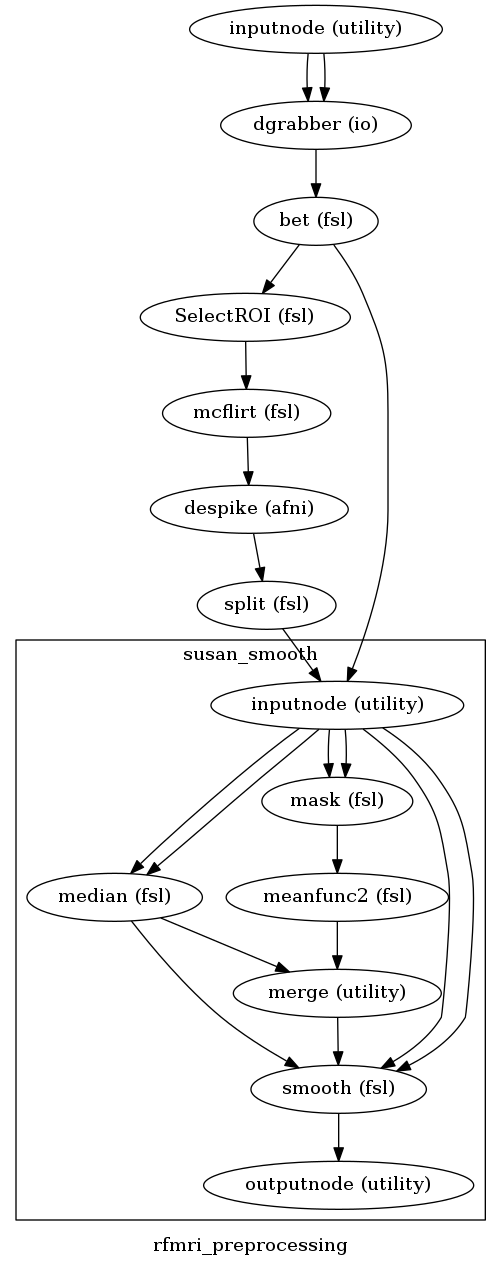

In [10]:
Image(wf.write_graph())

In [11]:
wf.run()

170329-19:51:47,763 workflow INFO:
	 Workflow rfmri_preprocessing settings: ['check', 'execution', 'logging']
170329-19:51:47,797 workflow INFO:
	 Running serially.
170329-19:51:47,801 workflow INFO:
	 Executing node dgrabber in dir: /home/jovyan/work/outputs/rfmri_preprocessing/dgrabber
170329-19:51:47,852 workflow INFO:
	 Executing node bet in dir: /home/jovyan/work/outputs/rfmri_preprocessing/bet
170329-19:51:47,889 workflow INFO:
	 Running: bet /home/jovyan/work/data/ds000114/sub-01/func/sub-01_task-fingerfootlips_bold.nii.gz /home/jovyan/work/outputs/rfmri_preprocessing/bet/sub-01_task-fingerfootlips_bold_brain.nii.gz -F -m
170329-19:51:53,33 workflow INFO:
	 Executing node SelectROI in dir: /home/jovyan/work/outputs/rfmri_preprocessing/SelectROI
170329-19:51:53,65 workflow INFO:
	 Running: fslroi /home/jovyan/work/outputs/rfmri_preprocessing/bet/sub-01_task-fingerfootlips_bold_brain.nii.gz /home/jovyan/work/outputs/rfmri_preprocessing/SelectROI/sub-01_task-fingerfootlips_bold_bra